In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Importing the Libraries

In [4]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

Creating Dataframe

In [5]:
tumor_dir=r'/content/gdrive/MyDrive/Dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
healthy_dir=r'/content/gdrive/MyDrive/Dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
filepaths = []
labels= []
# Creating dataframe by iterating through filepaths
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('cancer')
        else:
          labels.append('healthy')
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                                           filepaths  labels
0  /content/gdrive/MyDrive/Dataset/Brain Tumor Da...  cancer
1  /content/gdrive/MyDrive/Dataset/Brain Tumor Da...  cancer
2  /content/gdrive/MyDrive/Dataset/Brain Tumor Da...  cancer
3  /content/gdrive/MyDrive/Dataset/Brain Tumor Da...  cancer
4  /content/gdrive/MyDrive/Dataset/Brain Tumor Da...  cancer
cancer     2513
healthy    2087
Name: labels, dtype: int64


In [6]:
tumor_df.shape   #shape of datatset

(4600, 2)

Splitting Tumor Data using train_test_split

In [7]:
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [8]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3680, 2)
(1380, 2)
(920, 2)
(3220, 2)


Data Preprocessing

In [9]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
#Generate batches of tensor image data with real-time data augmentation.

Found 3680 validated image filenames belonging to 2 classes.


In [10]:
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )

Found 1380 validated image filenames belonging to 2 classes.


In [11]:
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 920 validated image filenames belonging to 2 classes.


In [12]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'healthy']


Visualizing Images of Brain

In [13]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

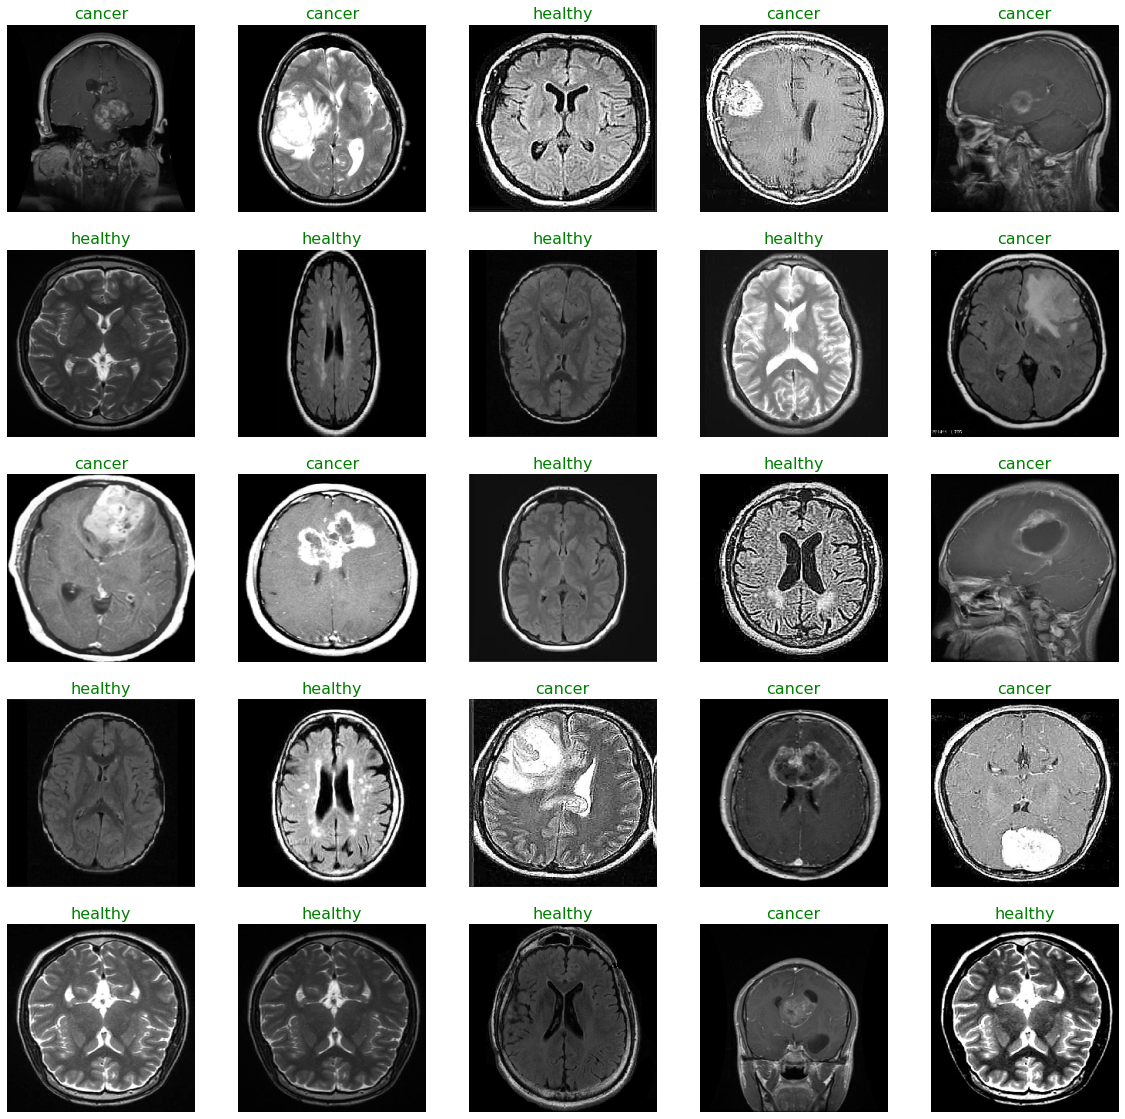

In [14]:
show_brain_images(train)

Model Training

In [15]:
#Custom Activation function
def LeakyReLU(alpha = 1):
    return lambda x : tf.keras.backend.maximum(alpha * x, x)

In [16]:
model = Sequential()
# defining conv-pool layer
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), activation="relu", padding="valid",
               input_shape=(244,244,3)))

model.add(BatchNormalization()) #add Batch Normalisation layer
model.add(MaxPooling2D(pool_size=(2,2)))

#adding flatten layer
model.add(Flatten())

#adding dense layers with dropout
model.add(Dense(128, activation=LeakyReLU(0.1)))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation=LeakyReLU(0.1)))
model.add(Dense(2, activation="sigmoid")) #Sigmoid is used for binary

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 242, 242, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 468512)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               59969664  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [18]:
History = model.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
115/115 [==============================] - 2038s 18s/step - loss: 1.2399 - accuracy: 0.7416 - val_loss: 0.3081 - val_accuracy: 0.8641
Epoch 2/10
115/115 [==============================] - 26s 228ms/step - loss: 0.2644 - accuracy: 0.9076 - val_loss: 0.2407 - val_accuracy: 0.9054
Epoch 3/10
115/115 [==============================] - 26s 226ms/step - loss: 0.1467 - accuracy: 0.9533 - val_loss: 0.2079 - val_accuracy: 0.9337
Epoch 4/10
115/115 [==============================] - 26s 228ms/step - loss: 0.1210 - accuracy: 0.9660 - val_loss: 0.1679 - val_accuracy: 0.9424
Epoch 5/10
115/115 [==============================] - 26s 227ms/step - loss: 0.0350 - accuracy: 0.9910 - val_loss: 0.2149 - val_accuracy: 0.9511
Epoch 6/10
115/115 [==============================] - 26s 227ms/step - loss: 0.0580 - accuracy: 0.9856 - val_loss: 0.3094 - val_accuracy: 0.9402
Epoch 7/10
115/115 [==============================] - 26s 228ms/step - loss: 0.0447 - accuracy: 0.9897 - val_loss: 0.1422 - val_ac

Visualizing Loss and Accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

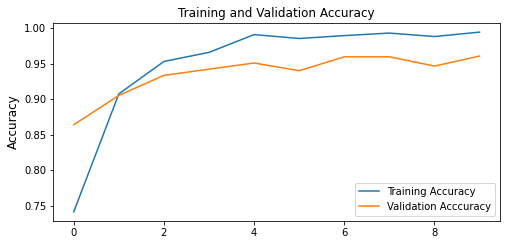

In [19]:
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Losses')

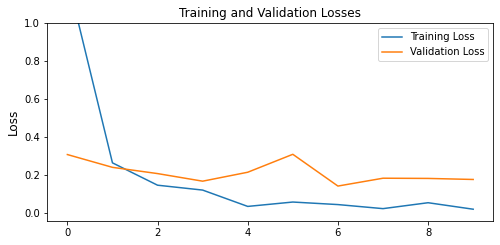

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
 
plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

In [21]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 7s 160ms/step - loss: 0.1184 - accuracy: 0.9739


[0.11836813390254974, 0.9739130139350891]

In [22]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [24]:
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

      cancer       0.96      0.99      0.98       779
     healthy       0.99      0.95      0.97       601

    accuracy                           0.97      1380
   macro avg       0.98      0.97      0.97      1380
weighted avg       0.97      0.97      0.97      1380



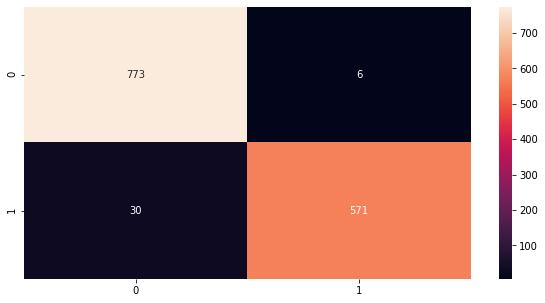

In [25]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

Checking the model

In [26]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

100.0% Confidence This Is Its a Tumor


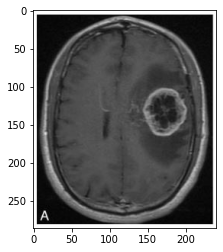

In [39]:
from matplotlib.pyplot import imshow
from PIL import Image
img = Image.open(r"/content/gdrive/MyDrive/Dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1016).JPG")
x = np.array(img.resize((244,244)))
x = x.reshape(1,244,244,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))

100.0% Confidence This Is No, Its not a tumor


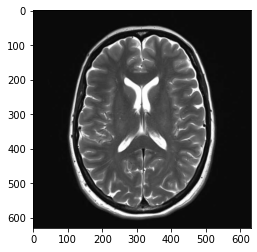

In [40]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/gdrive/MyDrive/Dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (10).jpg")
x = np.array(img.resize((244,244)))
x = x.reshape(1,244,244,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))